### Phase 1 - Problem Definition  
#### 1.1 Broad Goals  

The purpose of this study is to identify fraudulent transactions in an extremely unbalanced dataset.  

#### 1.2 Data Source

The data is courtesy of the PaySim synthetic dataset available on Kaggle.  
https://www.kaggle.com/ntnu-testimon/paysim1

"PaySim simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. The original logs were provided by a multinational company, who is the provider of the mobile financial service which is currently running in more than 14 countries all around the world."

The kaggle dataset is scaled back to 1/4 the size of the original and simulates 30 days of mobile money transactions.

#### 1.3 Problem Statement 

### Phase 2 - Data Gathering  
#### 2.1 Imports


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### 2.2 Load Data

In [6]:
df = pd.read_csv('data/PS_20174392719_1491204439457_log.csv')

In [7]:
df.head(2)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0


In [8]:
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})
# to make all columns camel case and labeled the same way

### Phase 3 - Exploratory Data Analysis  
#### 3.1 Dataset Shape

In [9]:
df.shape

(6362620, 11)

#### 3.2 Fraud by Transaction Type

In [10]:
df['isFlaggedFraud'].value_counts(normalize=True)

0    0.999997
1    0.000003
Name: isFlaggedFraud, dtype: float64

In [11]:
df['isFraud'].value_counts(normalize=True)

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

Okay, we're dealing with a very imbalanced group here.  That means we'll either need to correct the class imbalance or we'll have an extremely high bar to improve on.

In [12]:
df.groupby(by = ['type'])['isFraud'].value_counts(normalize = True)

type      isFraud
CASH_IN   0          1.000000
CASH_OUT  0          0.998160
          1          0.001840
DEBIT     0          1.000000
PAYMENT   0          1.000000
TRANSFER  0          0.992312
          1          0.007688
Name: isFraud, dtype: float64

At the moment we're ONLY seeing fraud samples in the CASH_OUT and TRANSFER categories.  We might be able to narrow our field of vision to focus on only these two categories.

In [13]:
df.groupby(by = ['type'])['isFraud'].value_counts()

type      isFraud
CASH_IN   0          1399284
CASH_OUT  0          2233384
          1             4116
DEBIT     0            41432
PAYMENT   0          2151495
TRANSFER  0           528812
          1             4097
Name: isFraud, dtype: int64

In [14]:
df = df[(df['type'] == 'CASH_OUT' ) | (df['type'] == 'TRANSFER')]

In [15]:
df['isFraud'].value_counts()

0    2762196
1       8213
Name: isFraud, dtype: int64

In [16]:
df['isFraud'].value_counts(normalize = True)

0    0.997035
1    0.002965
Name: isFraud, dtype: float64

In [17]:
df.groupby('nameDest')['isFraud'].value_counts(sort = True)

nameDest     isFraud
C1000004082  0           3
C1000004940  0          10
C1000013769  0           9
C100001587   0           5
C1000015936  0           8
                        ..
C999990488   0           1
C999991596   0           1
C999993662   0           2
C999996264   0           1
C999999956   0           2
Name: isFraud, Length: 514627, dtype: int64

Even in the categories that have confirmed fraud, we're only seeing 8.2k samples of fraud out of 2.7m samples.  Still a highly unbalanced class, although we've improved the positively identified cases from 0.13 % to 0.3 %.  This means that our baseline for our target column will need to be better than 99.7% accurate.  Let's see if we can improve on that.

In [18]:
df.groupby('isFraud')['nameDest'].value_counts()

isFraud  nameDest   
0        C1286084959    75
         C1360767589    68
         C665576141     68
         C97730845      67
         C248609774     64
                        ..
1        C998514614      1
         C999409522      1
         C999470580      1
         C999708230      1
         C999955448      1
Name: nameDest, Length: 514627, dtype: int64

In [19]:
fraud = df[df['isFraud']== 1]

In [20]:
fraud['nameDest'].value_counts()

C964377943     2
C686334805     2
C1656842502    2
C52390890      2
C1259079602    2
              ..
C605036987     1
C521066417     1
C1310890311    1
C2098386124    1
C1140210295    1
Name: nameDest, Length: 8169, dtype: int64

No target account has more than 2 fradulent transactions

In [21]:
fraud['nameOrig'].value_counts()

C229756338     1
C1640378409    1
C1134864869    1
C920057135     1
C517594835     1
              ..
C847645948     1
C1377280897    1
C776987005     1
C1227029335    1
C1127265876    1
Name: nameOrig, Length: 8213, dtype: int64

The destination accounts for fraud transactions occasionally have some overlap, the origin accounts do not.

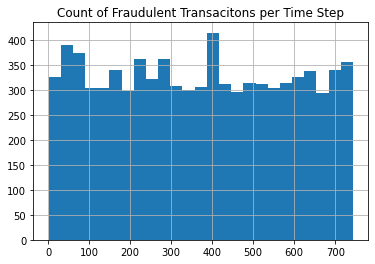

In [22]:
fraud['step'].hist(bins = 25)
plt.title("Count of Fraudulent Transacitons per Time Step")
plt.savefig('./imgs/fraudTransactionsPerStep.jpg')

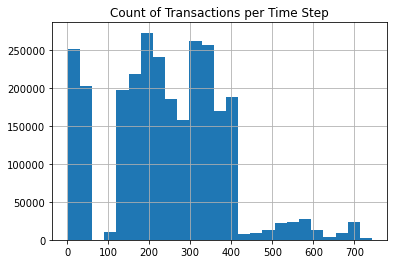

In [23]:
df['step'].hist(bins = 25)
plt.title("Count of Transactions per Time Step")
plt.savefig('./imgs/regTransactionsPerStep.jpg');

While we're seeing a bit of a spike in fraudulent transactions around the 400th hour of the time frame, the number of fraudulent transactions remains constant.  Interestingly, we're also seeing a dramatic dropoff in total transactions around that same timeframe.  Maybe we can look at percentage of fraud over time.

In [24]:
time_fraud = df.groupby('step').agg({'isFraud': 'sum'}, axis = 1)

In [25]:
time_fraud

,isFraud
step,
1,16
2,8
3,4
4,10
5,6
...,...
739,10
740,6
741,22


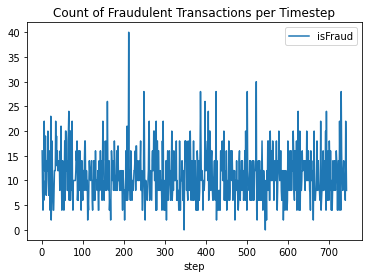

In [26]:
time_fraud.plot()
plt.title("Count of Fraudulent Transactions per Timestep")
plt.savefig('./imgs/nFraudPerStep.jpg')

Okay, let's get more of the dataframe on the number line.

In [27]:
def cust_or_merch(cell):
    if "M" in str(cell):
        return "M"
    else:
        return "C"
    
df['origAccountType'] = df['nameOrig'].apply(cust_or_merch)
df['destAccountType'] = df['nameDest'].apply(cust_or_merch)

In [28]:
df['origAccountType'].value_counts()

C    2770409
Name: origAccountType, dtype: int64

In [29]:
df['destAccountType'].value_counts(normalize = True)

C    1.0
Name: destAccountType, dtype: float64

"M" type accounts are merchants accounts, originating no transactions and receiving 33.8% of transactions.

In [30]:
df.groupby('destAccountType')['isFraud'].value_counts()

destAccountType  isFraud
C                0          2762196
                 1             8213
Name: isFraud, dtype: int64

And I'm not showing any merchant accounts being confirmed as fraudulent. The merchant prefix of 'M' does not appear to include any examples.  We'll leave this in for now to see if we can spot a correlation once we bring it to the number line, but we might ultimately drop it from the model as so far it seems an irrelevant feature.

the original paper associated with the PaySim software indicates that the standard method for fraud is in two steps.  

    1. Transfer to a fraudulent account   
    2. a CASH_OUT transaction from the same account   
    
Let's see if we can quantify the accounts where this happens.

In [31]:
notFraud = df[df['isFraud']== 0]

In [32]:
df = pd.get_dummies(columns = ['destAccountType', 'type'], drop_first = True, data = df)